In [17]:
import numpy as np
import torch
import tntorch as tn
from scipy.stats import multivariate_normal

num_dimensions = 2
mu = np.array([0.10, 0.10])  # Mean vector

cov_matrix = np.array([[0.20, 0.35],[ 0.16, 0.07]])  # Covariance matrix 
cov_matrix = 0.5 * (cov_matrix + cov_matrix.T)
cov_matrix = cov_matrix @ cov_matrix


def gaussian(x):
    return 1/ (((2 * np.pi) ** (num_dimensions) * np.abs(np.linalg.det(cov_matrix))) ** 0.5) * np.exp(-0.5 * ((x-mu).T @ np.linalg.inv(cov_matrix) @ (x-mu)))

d = 10

vectorized_function = [] #vettore vuoto
x_vals = np.linspace(mu[0] - 3*np.sqrt(cov_matrix[0,0]), mu[0] + 3*np.sqrt(cov_matrix[0,0]), 2**d)
y_vals = np.linspace(mu[1] - 3*np.sqrt(cov_matrix[1,1]), mu[1] + 3*np.sqrt(cov_matrix[1,1]), 2**d)
for x in x_vals:
    for y in y_vals[::-1]:
        vectorized_function.append(gaussian(np.array([x,y])))

vectorized_function = np.array(vectorized_function) # vettore probabilità discreta

shape = (2,)*(d*num_dimensions)         # (2,2,2,2)
A = vectorized_function.reshape(shape) #tensore numpy
T = tn.Tensor(A)      #tensore torch

print(shape)

TTrain = tn.cross(
    function=lambda x: x,   # identità su ciascuna fibra
    tensors=[T],            # lista di un solo tensore               # tolleranza desiderata
    ranks_tt=16,                 # rank massimo ammesso
)


print(TTrain)
print(A[0,0,1,1]) 

(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
cross device is cpu
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 20D domain containing 1.04858e+06 grid points:
iter: 0  | eps: 8.728e-06 | time:   0.1887 | largest rank:  16
iter: 1  | eps: 3.532e-06 | time:   0.2579 | largest rank:  16
iter: 2  | eps: 3.648e-06 | time:   0.3248 | largest rank:  16
iter: 3  | eps: 2.461e-06 | time:   0.3905 | largest rank:  16
iter: 4  | eps: 4.277e-06 | time:   0.4588 | largest rank:  16
iter: 5  | eps: 2.801e-06 | time:   0.5248 | largest rank:  16
iter: 6  | eps: 3.144e-06 | time:   0.5907 | largest rank:  16
iter: 7  | eps: 2.999e-06 | time:   0.6583 | largest rank:  16
iter: 8  | eps: 2.623e-06 | time:   0.7244 | largest rank:  16
iter: 9  | eps: 3.994e-06 | time:   0.7920 | largest rank:  16
ite

Did 341100 function evaluations, which took 0.001146s (2.976e+08 evals/s)

20D TT tensor:

  2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (10)(11)(12)(13)(14)(15)(16)(17)(18)(19)
 / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \
1   2   4   8   16  16  16  16  16  16  16  16  16  16  16  16  16  8   4   2   1

[[[[[[[[[[[[[[[[1.98479461e-13 2.13828762e-13]
               [2.30342741e-13 2.48108018e-13]]

              [[2.67217520e-13 2.87770929e-13]
               [3.09875163e-13 3.33644890e-13]]]


             [[[3.59203076e-13 3.86681573e-13]
               [4.16221745e-13 4.47975141e-13]]

              [[4.82104210e-13 5.18783069e-13]
               [5.58198317e-13 6.00549918e-13]]]]



            [[[[6.46052128e-13 6.94934497e-13]
               [7.47442933e-13 8.03840843e-13]]

              [[8

0.995400419274954


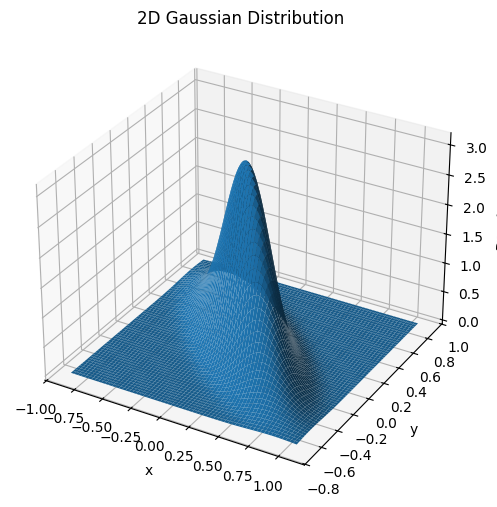

In [18]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

X, Y = np.meshgrid(x_vals, y_vals)
Z = vectorized_function.reshape((2**d, 2**d))

dx = x_vals[1] - x_vals[0]
dy = y_vals[1] - y_vals[0]
# somma doppia con rettangoli
integrale_num = np.sum(Z) * dx * dy

print(integrale_num)
Z = Z / integrale_num

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=16, cstride=16, linewidth=0, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Density')
ax.set_title('2D Gaussian Distribution')

plt.show()

In [19]:
cores_torch = TTrain.cores
cores = [c.cpu().numpy() for c in cores_torch]

import numpy as np

def contract_tt_cores(cores):
    """
    Contrai sequenzialmente i TT‐cores lungo le dimensioni di rango.
    Input:
      cores: lista di numpy array di shape (r_{k-1}, i_k, r_k)
    Output:
      array numpy del tensore completo di shape (i_1, i_2, ..., i_d)
    """
    # Partiamo dal primo core, shape (r0, i1, r1), tipicamente r0=1
    result = cores[0]

    # Per ogni core successivo, contrae l'ultimo asse di result (r_k)
    # con il primo asse del nuovo core (stesso r_k)
    for C in cores[1:]:
        # axes=([-1], [0]) = ultimo asse di result con primo asse di C
        result = np.tensordot(result, C, axes=([-1], [0]))
        # dopo la tensordot, le modalità si dispongono in questo ordine:
        # (..., i_k, r_k) ⨂ (r_k, i_{k+1}, r_{k+1})
        # → (..., i_k, i_{k+1}, r_{k+1})
    
    # Alla fine r_d = 1, quindi eliminiamo le dim singleton
    return np.squeeze(result)


# Esempio d’uso
# cores è la tua lista di array numpy di shape (r_{k-1}, i_k, r_k)
full_tensor = contract_tt_cores(cores)

print("Shape ricostruita:", full_tensor.shape)
# Dovrebbe stampare (2,2,2,2,2,2,2,2,2,2) per d=10 e tutti i modi di dimensione 2

Shape ricostruita: (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)


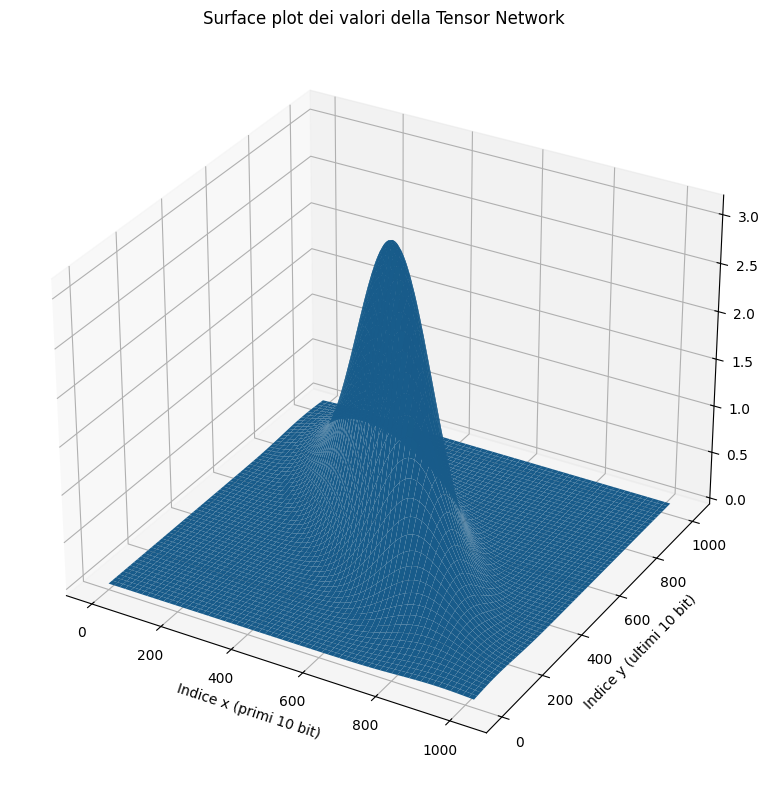

In [20]:
n_bits = 10
dim = 2**n_bits  # 1024

# Verifica
assert full_tensor.size == dim * dim, "Deve avere 2^(10+10) elementi"

# Rimodella in matrice 2D (1024×1024)
Z = full_tensor.reshape((dim, dim))

# Crea gli indici per x e y (0..1023)
x = np.arange(dim)
y = np.arange(dim)
X, Y = np.meshgrid(x, y)
dx = x_vals[1] - x_vals[0]
dy = y_vals[1] - y_vals[0]
# somma doppia con rettangoli
integrale_num = np.sum(Z) * dx * dy

# Plot 3D con Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Superficie
surf = ax.plot_surface(
    X, Y, Z / integrale_num,
    rstride=16, cstride=16,       # salta un punto ogni 16 per velocità
    linewidth=0, antialiased=True
)

ax.set_xlabel('Indice x (primi 10 bit)')
ax.set_ylabel('Indice y (ultimi 10 bit)')
ax.set_title('Surface plot dei valori della Tensor Network')

plt.tight_layout()
plt.show()

In [21]:
F = np.zeros((len(x_vals),len(x_vals)))
G = np.zeros((len(x_vals),len(x_vals)))

def gaussian_array(x_vec, y_vec):
    f = np.zeros((len(x_vec), len(y_vec)))
    inv_cov = np.linalg.inv(cov_matrix)
    norm_const = 1 / (((2 * np.pi) ** num_dimensions * np.abs(np.linalg.det(cov_matrix))) ** 0.5)
    for i in range(len(x_vec)):
        for j in range(len(y_vec)):
            x = np.array([x_vec[i], y_vec[j]])
            diff = x - mu
            f[i, j] = norm_const * np.exp(-0.5 * diff.T @ inv_cov @ diff)
    return f

distribuzione = gaussian_array(x_vals,y_vals) 

# Compute cumulative integrals via 2D cumulative sums
F = np.cumsum(np.cumsum(distribuzione, axis=0), axis=1) * dx * dy
G = np.cumsum(np.cumsum(Z, axis=0),       axis=1) * dx * dy / integrale_num

# Maximum absolute difference
D = np.max(np.abs(F - G))
print(D)

0.29421972745646896


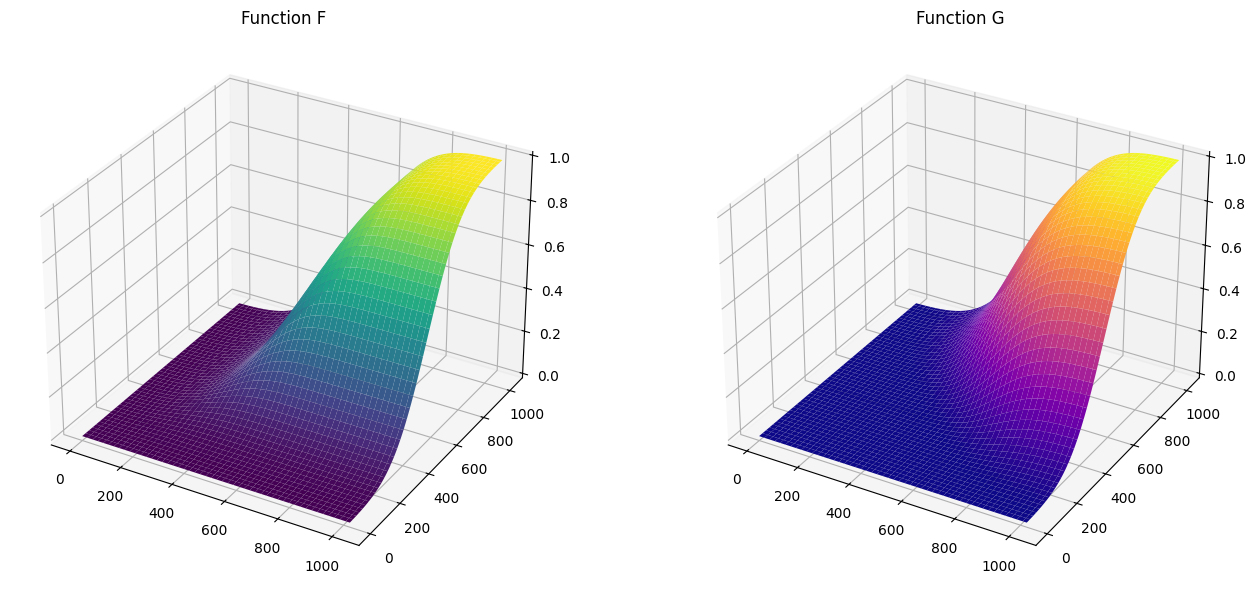

In [22]:
import matplotlib.patches as mpatches

# Assuming you’ve already computed:
# X, Y, Z, F, G, dx, dy, integrale_num, dim

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X,Y,F, cmap='viridis'); ax1.set_title('Function F')
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X,Y,G, cmap='plasma'); ax2.set_title('Function G')

# Labels, title
ax.set_xlabel('Indice x (primi 10 bit)')
ax.set_ylabel('Indice y (ultimi 10 bit)')
ax.set_title('Confronto 3D di F (verde) vs G (viola)')
#ax.view_init(elev=30, azim=10)


plt.tight_layout()
plt.show()

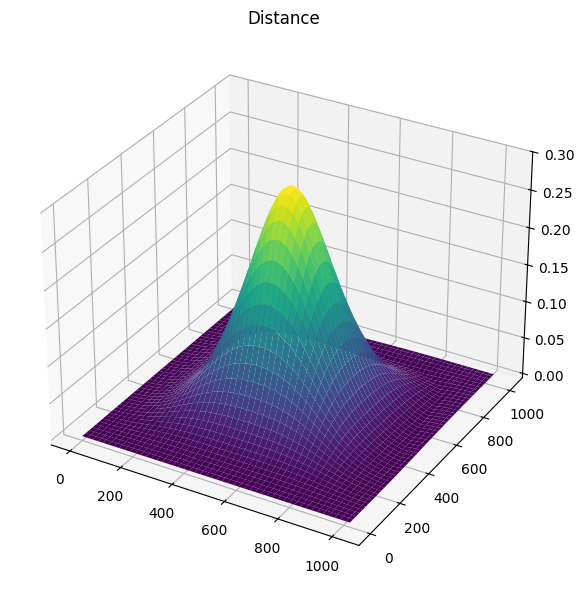

In [23]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X,Y,np.abs(F-G), cmap='viridis'); ax1.set_title('Distance')

# Labels, title
ax.set_xlabel('Indice x (primi 10 bit)')
ax.set_ylabel('Indice y (ultimi 10 bit)')
ax.set_title('Confronto 3D di F (verde) vs G (viola)')
#ax.view_init(elev=30, azim=10)


plt.tight_layout()
plt.show()